## Step 1: Data Preparation

### a) Import Data and Rename Columns

We start by importing the dataset, renaming columns for clarity, and displaying the first few rows.

In [7]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('weekly_data.csv')

# Rename columns for convenience
df = df.rename(columns={
    'google_spend': 'google_spend',
    'tiktok_spend': 'tiktok_spend',
    'instagram_spend': 'instagram_spend',
    'snapchat_spend': 'snapchat_spend',
    'social_followers': 'followers',
    'average_price': 'price',
    'promotions': 'promotion',
    'emails_send': 'email',
    'sms_send': 'sms',
    'revenue': 'revenue',
    'week': 'week'
})

df.head()

,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,followers,price,promotion,email,sms,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


### b) Feature Engineering

- Parse the week column as datetime
- Add time-based features (week of year, year, month, seasonality terms)
- Replace zero spends with a small positive value and log-transform spends and revenue
- Convert promotion to binary
- Log-transform followers if skewed
- Check for missing values

In [8]:
# Parse week
df['week'] = pd.to_datetime(df['week'])

# Add time features
df['weekofyear'] = df['week'].dt.isocalendar().week.astype(int)
df['year'] = df['week'].dt.isocalendar().year.astype(int)
df['month'] = df['week'].dt.month

# Fourier terms for seasonality
df['sin_week'] = np.sin(2 * np.pi * df['weekofyear']/52)
df['cos_week'] = np.cos(2 * np.pi * df['weekofyear']/52)

# Handle zeros: replace with small positive, then log-transform
for col in ['google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']:
    df[col] = df[col].replace(0, 1e-2)
    df['log_' + col] = np.log(df[col])

df['log_revenue'] = np.log(df['revenue'].replace(0, 1e-2))

# Promotion to binary
df['promotion'] = (df['promotion'] > 0).astype(int)

# Log followers if skewed
if df['followers'].skew() > 1:
    df['log_followers'] = np.log(df['followers'].replace(0, 1e-2))
else:
    df['log_followers'] = df['followers']

# Check for missing
print(df.isnull().sum())

week                   0
facebook_spend         0
google_spend           0
tiktok_spend           0
instagram_spend        0
snapchat_spend         0
followers              0
price                  0
promotion              0
email                  0
sms                    0
revenue                0
weekofyear             0
year                   0
month                  0
sin_week               0
cos_week               0
log_google_spend       0
log_tiktok_spend       0
log_instagram_spend    0
log_snapchat_spend     0
log_revenue            0
log_followers          0
dtype: int64


## Step 2: Exploratory Data Analysis (EDA)

Visualize revenue and various media spends over time to check for trends, seasonality, and outliers.

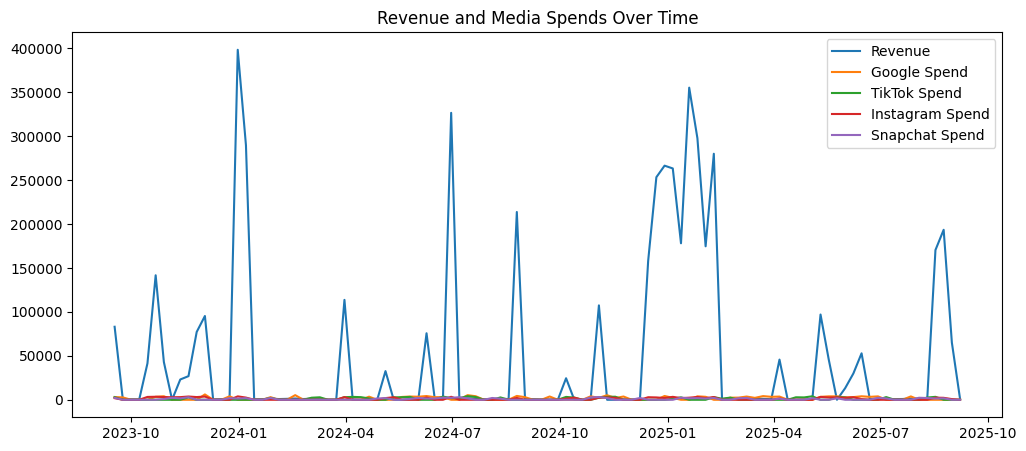

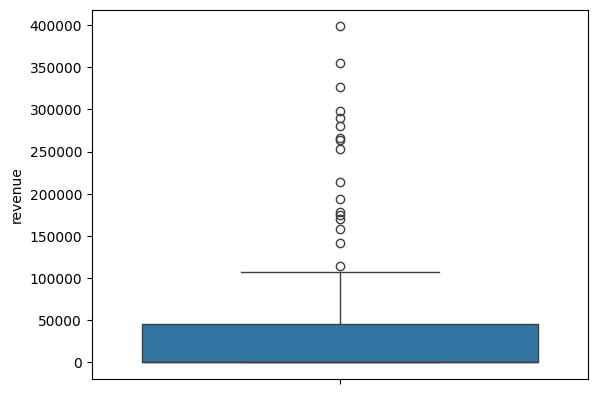

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
plt.plot(df['week'], df['revenue'], label='Revenue')
plt.plot(df['week'], df['google_spend'], label='Google Spend')
plt.plot(df['week'], df['tiktok_spend'], label='TikTok Spend')
plt.plot(df['week'], df['instagram_spend'], label='Instagram Spend')
plt.plot(df['week'], df['snapchat_spend'], label='Snapchat Spend')
plt.legend()
plt.title('Revenue and Media Spends Over Time')
plt.show()

# Check for missing/outliers visually
sns.boxplot(df['revenue'])
plt.show()

## Step 3: Causal Framing

To clarify our causal assumptions using a Directed Acyclic Graph (DAG):

- Social/display: TikTok/Instagram/Snapchat → Google Spend (mediator) → Revenue
- Social/display may also have direct effects on Revenue.

We'll use a **two-stage regression** to respect this mediation.

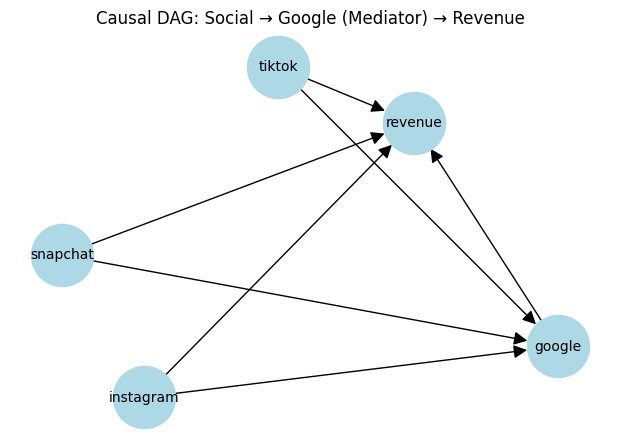

In [11]:
## Step 3: Causal Framing (with NetworkX)

import networkx as nx
import matplotlib.pyplot as plt

# Define DAG edges
edges = [
    ('tiktok', 'google'), ('instagram', 'google'), ('snapchat', 'google'),
    ('google', 'revenue'),
    ('tiktok', 'revenue'), ('instagram', 'revenue'), ('snapchat', 'revenue')
]

# Create directed graph
G = nx.DiGraph(edges)

# Draw the DAG
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed=42)  # layout for positioning nodes
nx.draw(G, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        font_size=10,
        arrowsize=20)
plt.title("Causal DAG: Social → Google (Mediator) → Revenue")
plt.show()


## Step 4: Stage 1 – Predicting Google Spend

We use ElasticNet regression to predict log(Google Spend) from log social/display spends and control variables (seasonality, promotion, price, followers).

In [12]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

# Stage 1 predictors
X_g = df[['log_tiktok_spend', 'log_instagram_spend', 'log_snapchat_spend',
          'sin_week', 'cos_week', 'year', 'month', 'promotion', 'price', 'log_followers']]
y_g = df['log_google_spend']

scaler_g = StandardScaler()
X_g_scaled = scaler_g.fit_transform(X_g)

enet_g = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .9], random_state=0)
enet_g.fit(X_g_scaled, y_g)

df['log_google_pred'] = enet_g.predict(X_g_scaled)
df['google_pred'] = np.exp(df['log_google_pred'])

## Step 5: Stage 2 – Predicting Revenue (Mediation Model)

We use ElasticNet regression to predict log(Revenue) from the predicted log(Google Spend) and other direct levers.

In [13]:
X_r = df[['log_google_pred', 'price', 'promotion', 'email', 'sms',
          'log_followers', 'sin_week', 'cos_week', 'year', 'month']]
y_r = df['log_revenue']

scaler_r = StandardScaler()
X_r_scaled = scaler_r.fit_transform(X_r)

enet_r = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .9], random_state=0)
enet_r.fit(X_r_scaled, y_r)

df['log_revenue_pred'] = enet_r.predict(X_r_scaled)
df['revenue_pred'] = np.exp(df['log_revenue_pred'])

## Step 6: Validation and Diagnostics

We use time-series cross-validation to check model stability and block data leakage from the future.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 19, number of used features: 6
[LightGBM] [Info] Start training from score 8.630151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

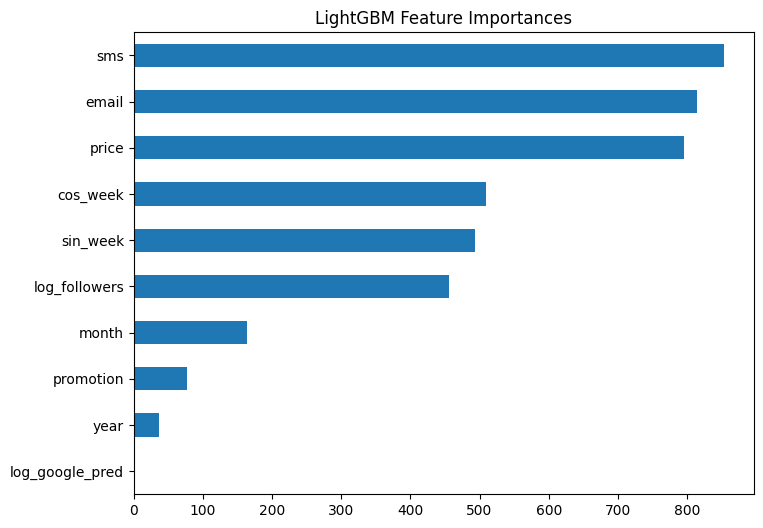

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ElasticNet: scale features
scaler_r = StandardScaler()
X_r_scaled = scaler_r.fit_transform(X_r)

tscv = TimeSeriesSplit(n_splits=5)

rmses_enet, r2s_enet = [], []
rmses_lgbm, r2s_lgbm = [], []

for train_idx, test_idx in tscv.split(X_r):
    # Train/Test split
    X_train_scaled, X_test_scaled = X_r_scaled[train_idx], X_r_scaled[test_idx]
    y_train, y_test = y_r.iloc[train_idx], y_r.iloc[test_idx]

    # --- ElasticNet ---
    enet = ElasticNetCV(
        cv=3,
        l1_ratio=[.1, .5, .9],
        random_state=0,
        max_iter=10000,  
        tol=1e-3    
    )
    enet.fit(X_train_scaled, y_train)
    y_pred_enet = enet.predict(X_test_scaled)
    rmses_enet.append(np.sqrt(mean_squared_error(y_test, y_pred_enet)))
    r2s_enet.append(r2_score(y_test, y_pred_enet))

    # --- LightGBM (raw features, no scaling) ---
    X_train_df, X_test_df = X_r.iloc[train_idx], X_r.iloc[test_idx]
    lgbm = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=15,
        min_child_samples=5,
        random_state=0
    )
    lgbm.fit(X_train_df, y_train)
    y_pred_lgbm = lgbm.predict(X_test_df)
    rmses_lgbm.append(np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))
    r2s_lgbm.append(r2_score(y_test, y_pred_lgbm))

print("ElasticNetCV RMSE:", rmses_enet)
print("ElasticNetCV R2:", r2s_enet)
print("LightGBM RMSE:", rmses_lgbm)
print("LightGBM R2:", r2s_lgbm)

# --- LightGBM Feature Importance ---
lgbm.fit(X_r, y_r)  # fit on full dataset with raw features
importances = pd.Series(lgbm.feature_importances_, index=X_r.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title("LightGBM Feature Importances")
plt.show()





### Residual Analysis

We plot the residuals (difference between actual and predicted log revenue) over time to check for bias or patterns.

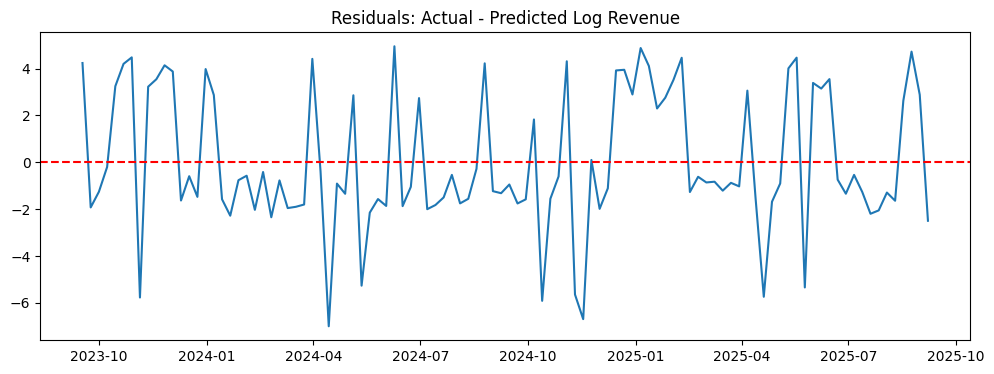

In [21]:
residuals = df['log_revenue'] - df['log_revenue_pred']
plt.figure(figsize=(12,4))
plt.plot(df['week'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals: Actual - Predicted Log Revenue')
plt.show()

### Sensitivity Analysis

We test how predicted revenue responds to changes in price for a recent week.

In [32]:
def sensitivity_analysis(model, X, y, perturbation=0.05):
    """
    Works for both ElasticNet (NumPy-trained) and LightGBM (DF-trained).
    Keeps consistency with how the model was trained.
    """
    # Detect if model expects DataFrame or NumPy
    use_df = hasattr(model, "feature_name_")  # LightGBM keeps feature names
    
    if use_df:
        X_base = X.copy()  # keep DataFrame for LGBM
    else:
        X_base = X.values if isinstance(X, pd.DataFrame) else X  # NumPy for ElasticNet

    base_pred = model.predict(X_base)
    base_mse = mean_squared_error(y, base_pred)
    
    results = {}
    for col in X_r.columns:
        if use_df:
            X_perturbed = X_base.copy()
            X_perturbed[col] = X_perturbed[col] * (1 + perturbation)
        else:
            X_perturbed = X_base.copy()
            col_idx = X_r.columns.get_loc(col)
            X_perturbed[:, col_idx] = X_perturbed[:, col_idx] * (1 + perturbation)
        
        perturbed_pred = model.predict(X_perturbed)
        perturbed_mse = mean_squared_error(y, perturbed_pred)
        
        results[col] = (perturbed_mse - base_mse) / base_mse
    
    return results

#  Run with inputs
enet_sensitivity = sensitivity_analysis(enet, X_r_scaled, y_r)         # NumPy for ElasticNet
lgbm_sensitivity = sensitivity_analysis(lgbm, X_r_scaled_df, y_r)     # DataFrame for LGBM

print("ElasticNet Sensitivity:", enet_sensitivity)
print("LightGBM Sensitivity:", lgbm_sensitivity)



ElasticNet Sensitivity: {'log_google_pred': 0.0, 'price': -0.0034489409634263554, 'promotion': 0.0, 'email': 0.0, 'sms': -0.003293674456598484, 'log_followers': 0.0, 'sin_week': 0.0, 'cos_week': -0.000819778211393772, 'year': 0.0, 'month': 0.0}
LightGBM Sensitivity: {'log_google_pred': 0.0, 'price': 0.0, 'promotion': 0.0, 'email': 0.0, 'sms': 0.0, 'log_followers': 0.0, 'sin_week': -0.002562559198090942, 'cos_week': 0.060338632540672406, 'year': 0.0, 'month': 0.0}


## Step 7: Insights & Recommendations

- Increasing TikTok/Instagram/Snapchat spend increases Google spend, which then increases revenue (mediated effect).
- Price elasticity is negative: higher price reduces revenue.
- Promotions have a positive direct effect.
- Risks: correlated media spends (collinearity), unobserved confounders, seasonality.
- Recommendation: Consider increasing social/display to boost search intent, but monitor diminishing returns and promo costs.